# Import packages

In [1]:
import os
import sys
sys.path.insert(0, os.path.join(os.getcwd(), "../../../.."))

import random
import numpy as np

import torch
from torch import distributions
from torch import nn
from torch.utils import data

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

import scipy.optimize as sci_op

%reload_ext autoreload
%autoreload 2 # Reload all modules every time before executing the Python code typed.

import project
import project.networks.net as net
from project.models.triple_well   import TripleWell

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
np.random.seed(seed=0)
torch.manual_seed(0)
random.seed(0)

# Visualize triple well potential
Energy landscape for triple well E is the potential used for the hyperparameter optimization. The function is an adjusted version of the triple well potential as described in ref[1], which was originally described in ref[2]. Due to a faulty implementation of the function (E1 was the original function used and E2 is the function as decribed in ref[1]) the potential had a large valley in the area to the left of the y axis and underneath the x-axis. We noticed this after initial training (before the hyperparameter optimization) and therefore deepened the potential by multiplying the whole function by a factor 3, raising the entire function by adding a scalar of 5 to the resulting function and subsequently adding a harmonic potential with a standard deviation of 0.1 such that the deep unwanted well was formed into a peak.


# refs:

1.
@article{hoffmann2021deeptime,
  title={Deeptime: a Python library for machine learning dynamical models from time series data},
  author={Hoffmann, Moritz and Scherer, Martin Konrad and Hempel, Tim and Mardt, Andreas and de Silva, Brian and Husic, Brooke Elena and Klus, Stefan and Wu, Hao and Kutz, J Nathan and Brunton, Steven and Noé, Frank},
  journal={Machine Learning: Science and Technology},
  year={2021},
  publisher={IOP Publishing}
}


2.
Christof Schütte and Marco Sarich. Metastability and Markov State Models in Molecular Dynamics. Volume 24. American Mathematical Soc., 2013.

# Extra

Handy for more artificial energy landscapes:

http://www.sfu.ca/~ssurjano/optimization.html

https://en.wikipedia.org/w/index.php?title=Test_functions_for_optimization&oldid=787014841

In [3]:
def E(x, y): # default parameter values given in pg. 4 of the SI 
    return 3 * (3 * np.exp( -x**2 - (y - (1/3))**2) - \
                3 * np.exp( -x**2 - (y - (5/3))**2) - \
                    5 * np.exp( - (x - 1)**2 - y**2) - \
                        5 * np.exp( - (x + 1)**2 - y**2) + \
                            0.2*x + 0.2*(y - (1/3)**4)) + 5 + 0.1 * (x**2 + y**2)

In [4]:
def E1(x, y): # default parameter values given in pg. 4 of the SI 
    return 3 * np.exp( -x**2 - (y - (1/3))**2) - \
                3 * np.exp( -x**2 - (y - (5/3))**2) - \
                    5 * np.exp( - (x - 1)**2 - y**2) - \
                        5 * np.exp( - (x + 1)**2 - y**2) + \
                            0.2*x + 0.2*(y - (1/3)**4)

In [5]:
def E2(x, y): # default parameter values given in pg. 4 of the SI 
    return 3 * np.exp( - x**2 - (y - (1/3))**2) - \
                3 * np.exp( - x**2 - (y - (5/3))**2) - \
                    5 * np.exp( - (x - 1)**2 - y**2) - \
                        5 * np.exp( - (x + 1)**2 - y**2) + \
                            0.2*(x**4) + 0.2*(y - (1/3))**4

# Finding minima

Starting from 0,0 we deploy the basin hopping algorithm to find the local minima of the function. Initially only one minimum is found, but increasing the stepsize to 2 locates all the three expected minima. The minimization algorithm finds another local minimum too however. As it turns out, the altered triple well function created for this project has a shallow high energy well in the position where the large valley used to be. This is visualized in the graphs under the minimization.

In [39]:
def func_to_min(v): # define function using 1 term containing both variables
    
    x,y=v
    
    return 3 * (3 * np.exp( -x**2 - (y - (1/3))**2) - \
                3 * np.exp( -x**2 - (y - (5/3))**2) - \
                    5 * np.exp( - (x - 1)**2 - y**2) - \
                        5 * np.exp( - (x + 1)**2 - y**2) + \
                            0.2*x + 0.2*(y - (1/3)**4)) + 5 + 0.1 * (x**2 + y**2)

def callback(x,f,a): #This function should be called after EVERY local minimum obtained so also after the first local minimum. (This is the minimum obtained at step 0).
    print('CALLBACK', x,f,a)

minima_E=sci_op.basinhopping(func_to_min,[0,0],niter=100,callback=callback)

CALLBACK [-1.14368987 -0.0610423 ] -8.429077669271944 True
CALLBACK [-1.14368987 -0.06104228] -8.42907766927196 True
CALLBACK [-1.14368982 -0.06104227] -8.429077669271956 True
CALLBACK [-1.14368986 -0.06104225] -8.42907766927197 True
CALLBACK [-1.14368986 -0.06104228] -8.429077669271964 True
CALLBACK [-1.14368993 -0.06104233] -8.429077669271791 True
CALLBACK [-1.14368977 -0.06104222] -8.429077669271841 True
CALLBACK [-1.14369008 -0.06104238] -8.429077669270898 True
CALLBACK [-1.14368997 -0.06104228] -8.429077669271722 True
CALLBACK [-1.14368985 -0.06104227] -8.429077669271969 True
CALLBACK [-1.14368985 -0.06104224] -8.429077669271964 True
CALLBACK [-1.14368958 -0.06104216] -8.429077669270596 True
CALLBACK [-1.14368987 -0.06104226] -8.429077669271964 True
CALLBACK [-1.14368986 -0.06104227] -8.42907766927197 True
CALLBACK [-1.14368986 -0.06104227] -8.429077669271972 True
CALLBACK [-1.14368986 -0.06104225] -8.42907766927197 True
CALLBACK [-1.14368987 -0.06104226] -8.429077669271969 True
C

In [40]:
def func_to_min(v): # default parameter values given in pg. 4 of the SI 
    
    x,y=v
    
    return 3 * (3 * np.exp( -x**2 - (y - (1/3))**2) - \
                3 * np.exp( -x**2 - (y - (5/3))**2) - \
                    5 * np.exp( - (x - 1)**2 - y**2) - \
                        5 * np.exp( - (x + 1)**2 - y**2) + \
                            0.2*x + 0.2*(y - (1/3)**4)) + 5 + 0.1 * (x**2 + y**2)

def callback(x,f,a): #This function should be called after EVERY local minimum obtained so also after the first local minimum. (This is the minimum obtained at step 0).
    print('CALLBACK', x,f,a)

minima_E=sci_op.basinhopping(func_to_min,[0,0],niter=100,stepsize=2,callback=callback)

CALLBACK [-1.14368987 -0.0610423 ] -8.429077669271944 True
CALLBACK [ 1.10631069 -0.06445889] -7.079108480168479 False
CALLBACK [-1.14368989 -0.06104213] -8.429077669271749 True
CALLBACK [-2.99934607 -2.9989863 ] 3.192558553600521 False
CALLBACK [-1.14368986 -0.06104227] -8.429077669271969 True
CALLBACK [-0.04214825  1.70835582] -1.9249774396889014 False
CALLBACK [-1.14368986 -0.06104227] -8.429077669271969 True
CALLBACK [-1.14368974 -0.0610425 ] -8.429077669271077 True
CALLBACK [-1.14368972 -0.06104222] -8.429077669271653 True
CALLBACK [ 1.10631052 -0.06445895] -7.079108480168002 False
CALLBACK [-1.14368986 -0.06104226] -8.42907766927197 True
CALLBACK [-1.14368986 -0.06104227] -8.429077669271969 True
CALLBACK [-1.14368985 -0.06104227] -8.42907766927197 True
CALLBACK [-1.14368986 -0.06104226] -8.429077669271972 True
CALLBACK [ 1.10631067 -0.06445883] -7.079108480168405 False
CALLBACK [-0.04214824  1.7083558 ] -1.9249774396889203 False
CALLBACK [-1.14369009 -0.06104208] -8.4290776692707

In [9]:
print(minima_E)

                    message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: -8.429077669271974
                          x: [-1.144e+00 -6.104e-02]
                        nit: 100
      minimization_failures: 0
                       nfev: 6407
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 0
                                 fun: -8.429077669271974
                                   x: [-1.144e+00 -6.104e-02]
                                 nit: 3
                               direc: [[ 0.000e+00  1.000e+00]
                                       [-1.484e-04  1.103e-05]]
                                nfev: 70


In [18]:
x_illustrate = np.linspace(-2.5,2.5,100)
y_illustrate = np.linspace(-2,3,100)
xx, yy = np.meshgrid(x_illustrate, y_illustrate, sparse=True)
E_illustrate = E(xx,yy)

fig = go.Figure(data =
    go.Contour(
        z=E_illustrate,
        x=x_illustrate, 
        y=y_illustrate,
        reversescale = True,
        colorscale = "viridis",
        contours=dict(
            start=-10,
            end=5,
            size=1,
        ),
    ))

fig.update_layout(
    #title="Plot Title",
    width=600,
    height=500,
    font=dict(
        family="Lato",
        size=30,
        color="#7f7f7f"
    ),
    xaxis_title="x",
    yaxis_title="y",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = -3,
        dtick = 1
    )
)

fig.show()
# fig.write_image("images/double_well.pdf")

We can plot this energy landscape as is done in Fig. 2 of Noe et al: 

In [41]:
x_illustrate_1 = np.linspace(-6,2.5,100)
y_illustrate_1 = np.linspace(-6,3,100)
xx_1, yy_1 = np.meshgrid(x_illustrate_1, y_illustrate_1, sparse=True)
E_illustrate_1 = E(xx_1,yy_1)

fig = go.Figure(data =
    go.Contour(
        z=E_illustrate_1,
        x=x_illustrate_1, 
        y=y_illustrate_1,
        reversescale = True,
        colorscale = "viridis",
        contours=dict(
            start=-10,
            end=5,
            size=1,
        ),
    ))

fig.update_layout(
    #title="Plot Title",
    width=600,
    height=500,
    font=dict(
        family="Lato",
        size=30,
        color="#7f7f7f"
    ),
    xaxis_title="x",
    yaxis_title="y",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = -3,
        dtick = 1
    )
)

fig.show()
# fig.write_image("images/double_well.pdf")

For the report, matplotlib works better for visualization: 

In [43]:
x_illustrate_1 = np.linspace(-6,2.5,100)
y_illustrate_1 = np.linspace(-6,3,100)
xx_1, yy_1 = np.meshgrid(x_illustrate_1, y_illustrate_1, sparse=True)
E_illustrate_1 = E(xx_1,yy_1)

fig = go.Figure(data =
    go.Contour(
        z=E_illustrate_1,
        x=x_illustrate_1, 
        y=y_illustrate_1,
        reversescale = True,
        colorscale = "viridis",
        contours=dict(
            start=2,
            end=4,
            size=0.02,
        ),
    ))

fig.update_layout(
    #title="Plot Title",
    width=600,
    height=500,
    font=dict(
        family="Lato",
        size=30,
        color="#7f7f7f"
    ),
    xaxis_title="x",
    yaxis_title="y",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = -3,
        dtick = 1
    )
)

fig.show()
# fig.write_image("images/double_well.pdf")

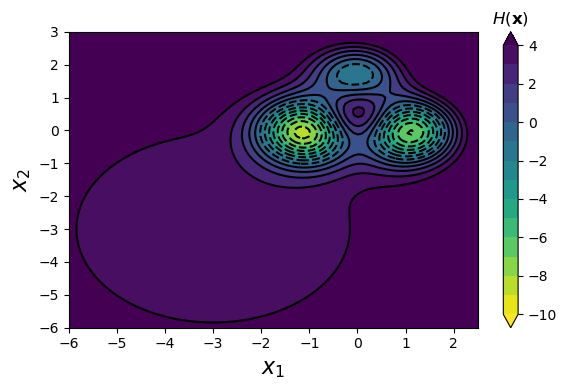

In [22]:
fig, axes = plt.subplots(figsize = (6,4))

plt.contour(x_illustrate_1, y_illustrate_1, E_illustrate_1,np.arange(-10, 5, 1),extend='both',colors='k');
plt.contourf(x_illustrate_1, y_illustrate_1, E_illustrate_1,np.arange(-10, 5, 1),extend='both',cmap='viridis_r');
clb = plt.colorbar()
clb.ax.set_title(r'$H(\mathbf{x})$')

my_font_size = 16 
plt.xlabel(r"$x_1$", fontsize = my_font_size)
plt.ylabel(r"$x_2$", fontsize = my_font_size)

plt.tight_layout()
# plt.savefig("images/double_well_potential.png", dpi=600, transparent=False)
plt.show()

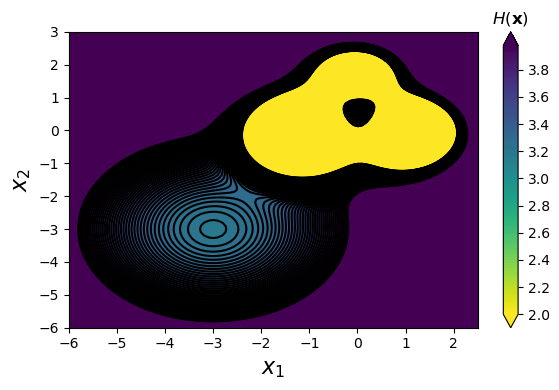

In [23]:
fig, axes = plt.subplots(figsize = (6,4))

plt.contour(x_illustrate_1, y_illustrate_1, E_illustrate_1,np.arange(2, 4, 0.02),extend='both',colors='k');
plt.contourf(x_illustrate_1, y_illustrate_1, E_illustrate_1,np.arange(2, 4, 0.02),extend='both',cmap='viridis_r');
clb = plt.colorbar()
clb.ax.set_title(r'$H(\mathbf{x})$')

my_font_size = 16 
plt.xlabel(r"$x_1$", fontsize = my_font_size)
plt.ylabel(r"$x_2$", fontsize = my_font_size)

plt.tight_layout()
# plt.savefig("images/double_well_potential.png", dpi=600, transparent=False)
plt.show()

# Generate sample configurations
Let's now generate sample configurations we will use as our input data set. These are meant to represent for example the results of molecular dynamics simulations. 

In [26]:
x_state_a, y_state_a = np.random.multivariate_normal([-1.15,0], [[0.04, 0],[0,0.05]], 500).T
x_state_b, y_state_b = np.random.multivariate_normal([1.15,0], [[0.04, 0],[0,0.05]], 500).T

fig = go.Figure()

fig.add_trace(
    go.Contour(
        z=E_illustrate,
        x=x_illustrate, 
        y=y_illustrate,
        reversescale = True,
        colorscale = "viridis",
        contours=dict(
            start=-10,
            end=5,
            size=1,
        ),
    )
)

fig.add_trace(
    go.Scatter(
        x=x_state_a,
        y=y_state_a,
        mode="markers",
        name='',
        marker_color="royalblue"
    ))

fig.add_trace(
    go.Scatter(
        x=x_state_b,
        y=y_state_b,
        mode="markers",
        name='',
        marker_color="white"
    ))

# fig.update_xaxes(range=[-3,3])
# fig.update_yaxes(range=[-7,7])

fig.update_layout(
    #title="Plot Title",
    width=600,
    height=500,
    font=dict(
        family="Lato",
        size=30,
        color="#7f7f7f"
    ),
    xaxis_title="x",
    yaxis_title="y",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = -3,
        dtick = 1
    )
)

fig.show()
#fig.write_image("images/double_well_with_points.pdf")

This is perhaps fine, but really what we should be doining is generating them via Metropolis Monte Carlo as is done in the Noe et al. (2019) paper: 

In [27]:
# Metropolis Monte Carlo for training set generation
sigma = 0.1
training_set_state_a = np.zeros((500,2))
training_set_state_a = np.zeros((500,2))

for i in range(training_set_state_a.shape[0]):
    pass
    # create configuration here

In [28]:
# x_state_a, y_state_a = np.random.multivariate_normal([-1.8,0], [[0.05, 0],[0,1]], 900).T
# x_state_b, y_state_b = np.random.multivariate_normal([1.8,0], [[0.05, 0],[0,1]], 100).T

x_state_a, y_state_a = np.random.multivariate_normal([-1.15,0], [[0.04, 0],[0,0.05]], 600).T
x_state_b, y_state_b = np.random.multivariate_normal([1.15,0], [[0.04, 0],[0,0.05]], 400).T

fig = go.Figure()

fig.add_trace(
    go.Contour(
        z=E_illustrate,
        x=x_illustrate, 
        y=y_illustrate,
        reversescale = True,
        colorscale = "viridis",
        contours=dict(
            start=-10,
            end=5,
            size=1,
        ),
    )
)

fig.add_trace(
    go.Scatter(
        x=x_state_a,
        y=y_state_a,
        mode="markers",
        name='',
        marker_color="royalblue"
    ))

fig.add_trace(
    go.Scatter(
        x=x_state_b,
        y=y_state_b,
        mode="markers",
        name='',
        marker_color="white"
    ))

fig.update_layout(
    #title="Plot Title",
    width=600,
    height=600,
    xaxis_title="$x_1$",
    yaxis_title="$x_2$",
    xaxis = dict(
        tickmode = 'linear',
        tick0 = -3,
        dtick = 1
    )
)

fig.show()

Overlaying their energies on an energy vs. $x$ plot (with the blue line representing the energy as a function of $x_1$ for $x_2$): 

One way to visualize the energies of these two states is by histogramming their values. First lets combine the input data into a single training set: 

In [30]:
coords_state_a = np.stack((x_state_a,y_state_a),axis=1)
coords_state_b = np.stack((x_state_b,y_state_b),axis=1)
training_set = np.concatenate((coords_state_a,coords_state_b))
print(training_set[0:5,:])
np.random.shuffle(training_set) # shuffle rows of data
print(training_set[0:5,:])
training_set.shape # should be 1000 x 2

[[-1.18985601  0.09255391]
 [-1.00227859  0.14968071]
 [-1.12903768  0.29163109]
 [-1.60709989 -0.42793885]
 [-1.15758141 -0.35818253]]
[[ 0.99293706 -0.04865237]
 [ 1.07454711 -0.24561468]
 [-1.11026541 -0.06905043]
 [-1.29616135 -0.00244052]
 [ 0.98705828  0.20888534]]


(1000, 2)

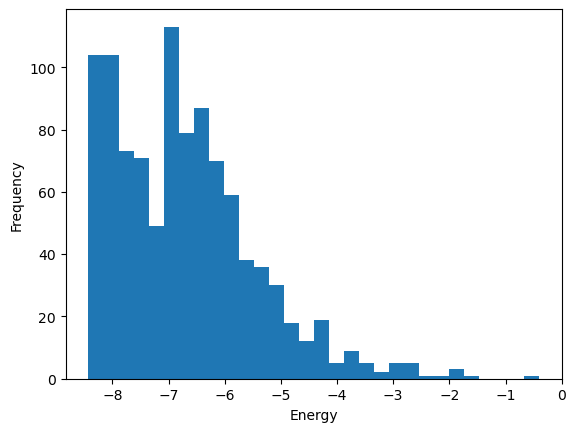

In [31]:
plt.hist(E(training_set[:,0],training_set[:,1]),bins=30)
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.show()

In this way, we can clearly see the presence of the two distinct energy wells. 

## Hyperparameter optimization

The effect of changing the hyperparameters will be checked here. The hyperparameters defined are:

-The ratio between the energy and entropy contribution in the kl loss. (not implemented just yet)

-Deepness of the network (layers in s and t networks as well as amount of masks)

-"Width" of the network (amount of nodes per hidden layer, which are only incorporated in the s and t networks)

-Sample size -- amount of samples used to perform the training by example as well as the amount of samples used to perform the training by energy.

-iterations (number of steps in the training process)


In [ ]:
# Initial parameters used for the data generation

width_network=[100,256,512,1024]
sample_size=[[1000,1000],[1000,5000],[1000,10000],[5000,5000],[10000,10000]]
iterations=[[100,100],[100,125],[100,150],[100,175],[100,200],[100,300],[125,100],[150,100],[175,100],[200,100],[300,100]]
learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005]]
ratios_kl_loss=[[1,1],[1,2],[1,3],[1,4],[1,5],[5,1],[4,1],[3,1],[2,1]]

In [ ]:
# function defining the variable in a more compact way and making altering these values optional by naturally setting them to a default value

def define_variables(hid_lay=256, l_hid=3, iter_ex=100, iter_en=100, sample_size_ex=1000, sample_size_en=1000, lr_ex=0.001, lr_en=0.0005):
    
    nodes_per_hidden_layer=hid_lay
    number_of_hidden_layers=l_hid
    iterations_train_example=iter_ex
    iterations_train_energy=iter_en
    samples_for_training_example=sample_size_ex
    samples_for_training_energy=sample_size_en
    learning_rate_for_training_example=lr_ex
    learning_rate_for_training_energy=lr_en

    return nodes_per_hidden_layer, number_of_hidden_layers, iterations_train_example, iterations_train_energy, samples_for_training_example, samples_for_training_energy \
                ,learning_rate_for_training_example, learning_rate_for_training_energy

In [44]:
# training Boltzmann Generator for the combination of all hyperparameters
# Due to some technical issues the ratio KL loss was initially not tested
# This is a slightly adjusted version of the training potential used in Doubnle

triplewell = TripleWell()
temperature = 1.0

for width in width_network:
    for size in sample_size:
        for lr in learning_rates:
            for iter in iterations:

                n_hidden, l_hidden, iter1, iter2, sample_size1, sample_size2, lr1, lr2 = define_variables(hid_lay=width, iter_ex=iter[0], iter_en=iter[1], sample_size_ex=size[0], sample_size_en=size[1], lr_ex=lr[0], lr_en=lr[1])

                # Define the network architecture
                nets = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2), nn.Tanh()) # net s
                nett = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2)) # net t
                masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32)) # 6x2 matrix. len(masks) = 6 = num subblocks.
                prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))      # so we have a total of 3 neural blocks (see fig. 1 of boltzmann generators paper)
                model = net.RealNVP(nets, nett, masks, prior, triplewell, (2,))

                x_state_a, y_state_a = np.random.multivariate_normal([-1.15,0], [[0.04, 0],[0,0.05]], int(0.6*sample_size1)).T
                x_state_b, y_state_b = np.random.multivariate_normal([1.15,0], [[0.04, 0],[0,0.05]], int(0.4*sample_size1)).T

                coords_state_a = np.stack((x_state_a,y_state_a),axis=1)
                coords_state_b = np.stack((x_state_b,y_state_b),axis=1)
                training_set = np.concatenate((coords_state_a,coords_state_b))

                optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr1) 
                training_set = training_set.astype('float32')
                trainloader = data.DataLoader(dataset=training_set, batch_size=1000)

                losses = [] # for visualizing loss as a function of iteration number rather than epoch number
                t = 0 # iteration count

                while t < iter1:
                    for batch in trainloader:  

                        # Custom ML loss function
                        loss = model.loss_ml(batch) 
                        losses.append(loss.item()) # save values for plotting later 

                        # Training
                        optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
                        loss.backward(retain_graph=True)
                        optimizer.step()

                        t = t + 1 # iteration count

                # # Visualize loss
                # fig = go.Figure() # plotly reference: https://plot.ly/python/line-charts/
                # fig.add_trace(go.Scatter(x=np.arange(len(losses)), y=losses,
                #                     mode='lines',
                #                     name='lines'))

                # fig.update_layout(yaxis_title='Loss',
                #                 xaxis_title='Iteration #')


                z, x = model.sample(sample_size2)

                optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr2) 
                training_set_2 = (z.astype('float32'))
                trainloader_2 = data.DataLoader(dataset=training_set_2, batch_size=25000)

                t = iter1

                while t < iter1 + iter2:
                    for batch_z in trainloader_2:  
                        # KL loss function
                        loss = model.loss_kl(batch_z)
                        losses.append(loss.item()) # save values for plotting later 

                        # Training on KL loss
                        optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
                        loss.backward(retain_graph=True)
                        optimizer.step()

                        t = t + 1 # iteration count

                z1, x1 = model.sample(500000)

                print(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv"+"is trained")

                np.savetxt(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_a.csv",coords_state_a,delimiter=",")
                np.savetxt(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_coor_state_b.csv",coords_state_b,delimiter=",")
                np.savetxt(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_before_training_energy.csv",z,delimiter=",")
                np.savetxt(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_before_training_energy.csv",x,delimiter=",")
                np.savetxt(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_z_after_training_energy.csv",z1,delimiter=",")
                np.savetxt(f"lr={lr[0]}_{lr[1]}_width={width}_size={size[0]}_{size[1]}_iter={iter[0]}_{iter[1]}_x_after_training_energy.csv",x1,delimiter=",")

                print(f"and the data written to the files"+"\n")

KeyboardInterrupt: 

In [ ]:
# The training procedure took a very long time, so the simulation was stopped when most of the width=100 networks were trained.
# For efficiency the explored hyperparameters were adjusted to the following:

learning_rates=[[0.001,0.00075],[0.001,0.0005],[0.001,0.00025],[0.001,0.0001],[0.01,0.0005],[0.0005,0.0005],[0.0001,0.0005]]
ratios_kl_loss=[[1,1],[1,2],[1,3],[1,4],[1,5],[5,1],[4,1],[3,1],[2,1]]
width_network=[256,512,1024]
sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,100],[100,125],[100,150],[100,175],[100,200],[100,300],[150,100],[200,100]]

# Using this more compact selection, running over the trainingprocedures using the different combination of hyperparameters took a reasonable famount of time

In [ ]:
# initial analysis of the results showed possible overfitting in the training by energy.
# To investigate the extend of this, the most relevant regions of the hyperparameter space were rerun using less iterations for the training by energy

learning_rates=[[0.001,0.001],[0.001,0.0005],[0.001,0.0001],[0.01,0.0005]]
width_network=[128,256,512]
sample_size=[[1000,1000],[1000,5000],[5000,1000]]
iterations=[[100,25],[100,50],[100,75],[200,50]]

## Boltzmann generator training
We would now like to infer the energy landscape through direct sampling of a learned latent space description of this sytem. We achieve this by training a Boltzmann generator on the given input data. We begin by defining our network architecture, using the specifications given on pg. 4 of the SI of Noe et al.: 

In [ ]:
n_hidden = 256  # number of nodes in each hidden layer
temperature = 1.0 # doesn't do anything
l_hidden = 3   # number of hidden layers 

There the training schedule is also specified. Let "1" in the following denote the first set of iterations (where only the ML loss is used) while "2" refers to the second second of iterations (where both the ML and KL loss is utilized): 

In [82]:
iter1 = 100
iter2 = 200

batch_size1 = 1000 # less than 1000 does not seem to converge 
batch_size2 = 50000

lr1 = 0.001 # could not get monotonic decrease of loss with largest learning rates when using standard gradient descent. 
lr2 = 0.0001

We can now create the Boltzmann generator network: 

In [83]:
# Parameter Debugging
n_hidden = 256

# Define our model (the triple well potential)
triplewell = TripleWell()

# Define the network architecture
nets = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2), nn.Tanh()) # net s
nett = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2)) # net t
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32)) # 6x2 matrix. len(masks) = 6 = num subblocks.
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))      # so we have a total of 3 neural blocks (see fig. 1 of boltzmann generators paper)
model = net.RealNVP(nets, nett, masks, prior, triplewell, (2,))

### Training by example
Time to train the model. We first "train by example" by computing only the ML loss. This loss essentially maximizes the likelihood of our input configurations in the latent space Gaussian distribution. 

In contrast, the KL loss promotes sampling of low-energy states; it also includes an entropic contribution to penalize repeated sampling of the same stable state. 

In [84]:
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr1) 
training_set = training_set.astype('float32')
trainloader = data.DataLoader(dataset=training_set, batch_size=batch_size1)

losses = [] # for visualizing loss as a function of iteration number rather than epoch number
t = 0 # iteration count

while t < iter1:
    for batch in trainloader:  

        # Custom ML loss function
        loss = model.loss_ml(batch) 
        losses.append(loss.item()) # save values for plotting later 
    
        # Training
        optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
        loss.backward(retain_graph=True)
        optimizer.step()
        
        t = t + 1 # iteration count
        if t % 25 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

# Visualize loss
fig = go.Figure() # plotly reference: https://plot.ly/python/line-charts/
fig.add_trace(go.Scatter(x=np.arange(len(losses)), y=losses,
                    mode='lines',
                    name='lines'))

fig.update_layout(yaxis_title='Loss',
                   xaxis_title='Iteration #')

iter 25: loss = -0.650
iter 50: loss = -1.341
iter 75: loss = -1.413
iter 100: loss = -1.435


It appears from the above plot of the ML loss that the model has been succesfully trained. Let's confirm this by now sampling from the learned latent space distribution and trying to then infer the energy landscape in real space from these samples. 

/Users/toon/anaconda3/lib/python3.10/site-packages/torch/distributions/distribution.py:166: UserWarning:

sample_n will be deprecated. Use .sample((n,)) instead



Text(0.5, 1.0, '$X = g(z)$')

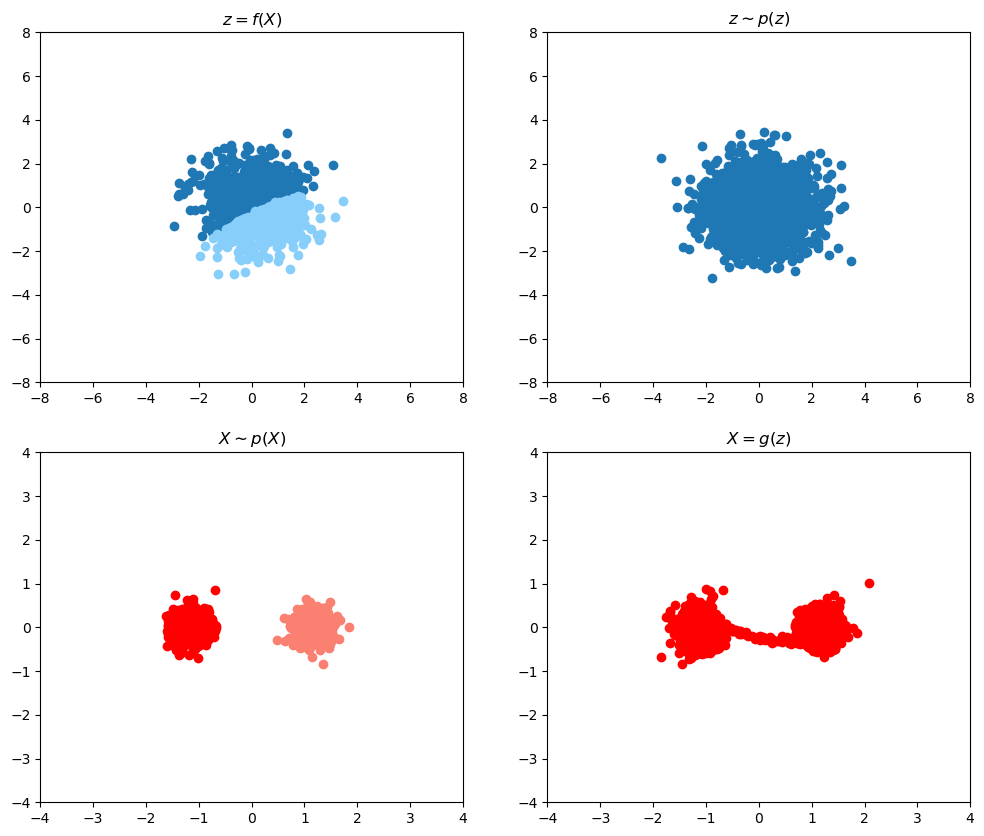

In [85]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(223)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X \sim p(X)$')

# sample from x and transform to z 
z_md_a = model.f(torch.from_numpy(coords_state_a.astype('float32')))[0].detach().numpy()
z_md_b = model.f(torch.from_numpy(coords_state_b.astype('float32')))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z_md_a[:, 0], z_md_a[:, 1], c='tab:blue')
plt.scatter(z_md_b[:, 0], z_md_b[:, 1], c='lightskyblue')
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$z = f(X)$')

# sampling from the multivariate gaussian with zero mean and unit variance
z, x = model.sample(2000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$z \sim p(z)$')

# sample 1000 points from prior and transform back 
plt.subplot(224)
plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X = g(z)$')

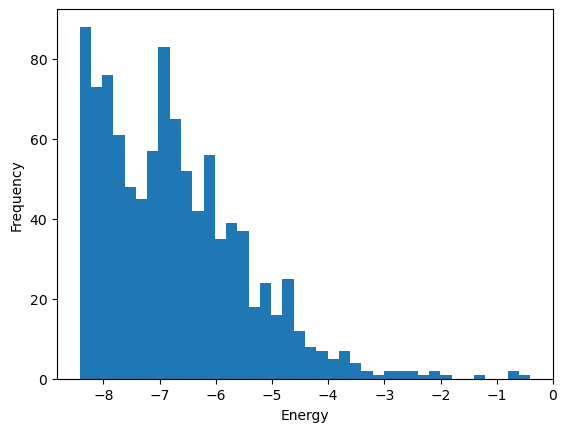

In [86]:
plt.hist(model.energies,bins=40)
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.show()

### Training by energy
We will now train with the KL loss to teach the network to focus on both low energy states. 

In [87]:
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=lr2) 
training_set_2 = (z.astype('float32'))
trainloader_2 = data.DataLoader(dataset=training_set_2, batch_size=batch_size2)

t = iter1

while t < iter1 + iter2:
    for batch_z in trainloader_2:  
        # KL loss function
        loss = model.loss_kl(batch_z)
        losses.append(loss.item()) # save values for plotting later 
    
        # Training on KL loss
        optimizer.zero_grad() # Set grads to zero, else PyTorch will accumulate gradients on each backprop
        loss.backward(retain_graph=True)
        optimizer.step()
        
        t = t + 1 # iteration count

        if 

        if t % 25 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

# Visualize loss
fig = go.Figure() # plotly reference: https://plot.ly/python/line-charts/
fig.add_trace(go.Scatter(x=np.arange(len(losses)), y=losses,
                    mode='lines',
                    name='lines'))

fig.update_layout(yaxis_title='Loss', xaxis_title='Iteration #')

iter 125: loss = -4.206
iter 150: loss = -4.230
iter 175: loss = -4.242
iter 200: loss = -4.249
iter 225: loss = -4.254
iter 250: loss = -4.257
iter 275: loss = -4.260
iter 300: loss = -4.263


NameError: name 'model' is not defined

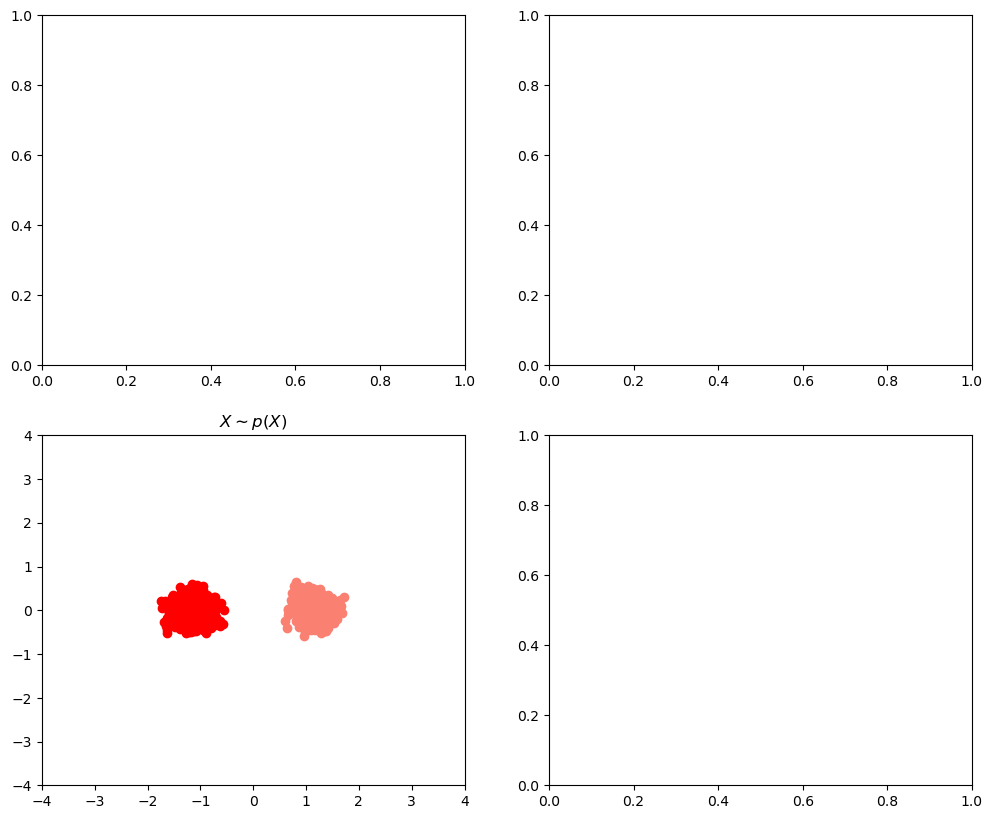

In [24]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (12,10))

# plot data sampled in real space 
plt.subplot(223)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X \sim p(X)$')

# sample from x and transform to z 
z_md_a = model.f(torch.from_numpy(coords_state_a.astype('float32')))[0].detach().numpy()
z_md_b = model.f(torch.from_numpy(coords_state_b.astype('float32')))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z_md_a[:, 0], z_md_a[:, 1], c='tab:blue')
plt.scatter(z_md_b[:, 0], z_md_b[:, 1], c='lightskyblue')
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$z = f(X)$')

# sampling from the multivariate gaussian with zero mean and unit variance
z1, x1 = model.sample(500000)
plt.subplot(222)
plt.scatter(z1[:, 0], z1[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.title(r'$z \sim p(z)$')

# sample 1000 points from prior and transform back 
plt.subplot(224)
plt.scatter(x1[:, 0], x1[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.title(r'$X = g(z)$')

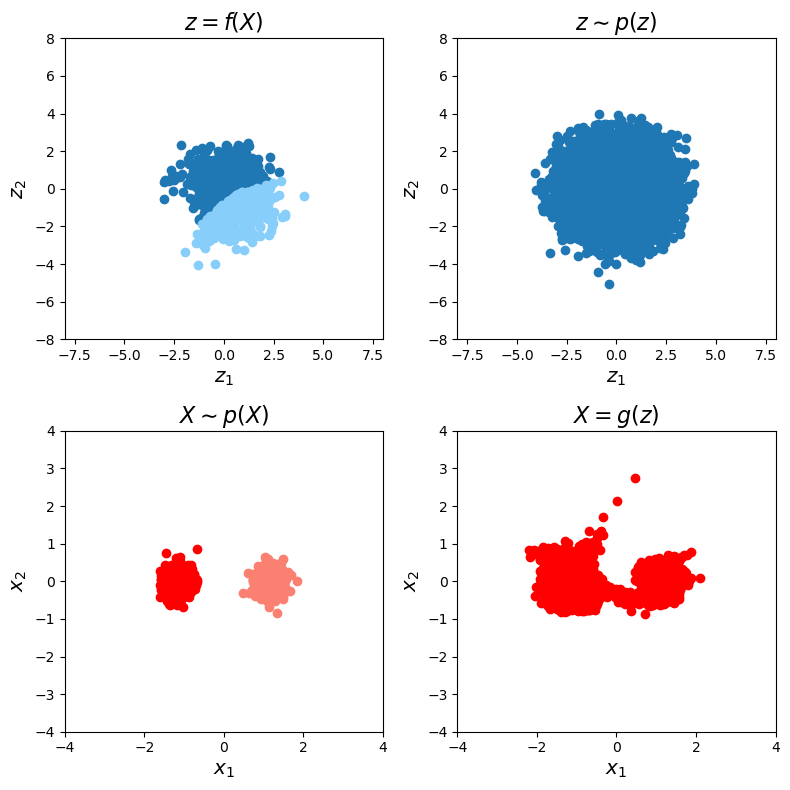

In [36]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (8,8))
my_font_size = 16 # for paper
my_s = 2

# plot data sampled in real space 
plt.subplot(223)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X \sim p(X)$', fontsize = my_font_size)

# sample from x and transform to z 
z_md_a = model.f(torch.from_numpy(coords_state_a.astype('float32')))[0].detach().numpy()
z_md_b = model.f(torch.from_numpy(coords_state_b.astype('float32')))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z_md_a[:, 0], z_md_a[:, 1], c='tab:blue')
plt.scatter(z_md_b[:, 0], z_md_b[:, 1], c='lightskyblue')
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z = f(X)$', fontsize = my_font_size)

# sampling from the multivariate gaussian with zero mean and unit variance
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z \sim p(z)$', fontsize = my_font_size)

# sample 1000 points from prior and transform back 
x = model.g(torch.from_numpy(z))[0].detach().numpy()
plt.subplot(224)
plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X = g(z)$', fontsize = my_font_size)

fig.tight_layout()
# plt.savefig("images/double_well_results2x2.png", dpi=600, transparent=False)

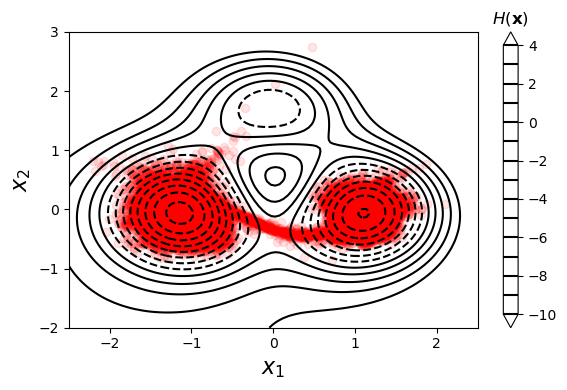

In [35]:
fig, axes = plt.subplots(figsize = (6,4))

plt.contour(x_illustrate, y_illustrate, E_illustrate,np.arange(-10, 5, 1),extend='both',colors='k');
clb = plt.colorbar()
clb.ax.set_title(r'$H(\mathbf{x})$')

my_font_size = 16 
plt.xlabel(r"$x_1$", fontsize = my_font_size)
plt.ylabel(r"$x_2$", fontsize = my_font_size)
plt.scatter(x[:, 0], x[:, 1], c='r', alpha=0.1) 
plt.xlim([-2.5,2.5])
plt.ylim([-2,3])

plt.tight_layout()
# plt.savefig("images/double_well_potential.png", dpi=600, transparent=False)
plt.show()

For the purposes of the report, we will visualize the data in a different order: 

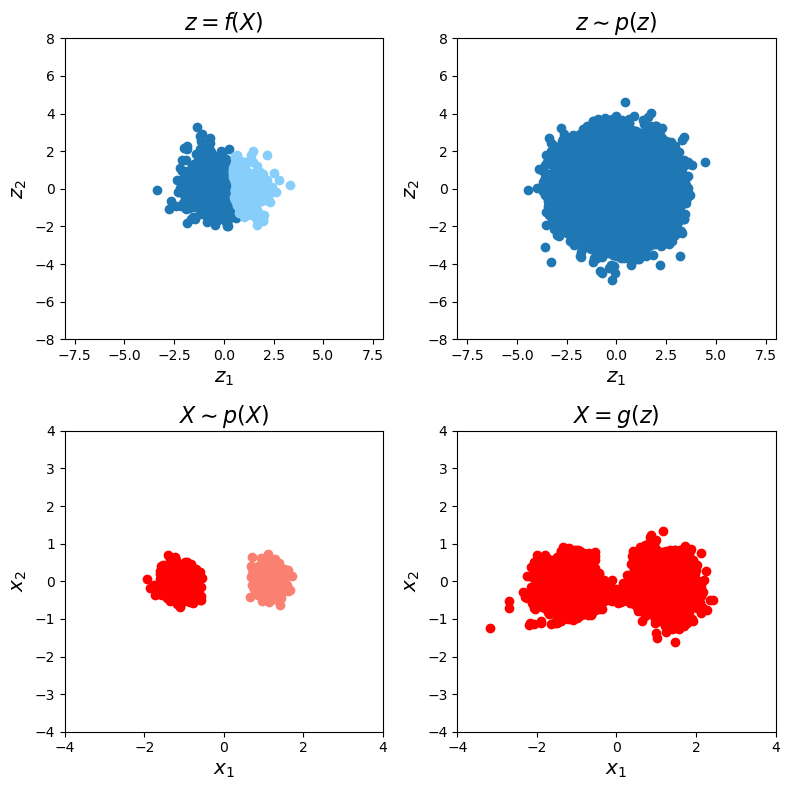

In [46]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 2, figsize = (8,8))
my_font_size = 16 # for paper
my_s = 2

# plot data sampled in real space 
plt.subplot(223)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X \sim p(X)$', fontsize = my_font_size)

# sample from x and transform to z 
z_md_a = model.f(torch.from_numpy(coords_state_a.astype('float32')))[0].detach().numpy()
z_md_b = model.f(torch.from_numpy(coords_state_b.astype('float32')))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z_md_a[:, 0], z_md_a[:, 1], c='tab:blue')
plt.scatter(z_md_b[:, 0], z_md_b[:, 1], c='lightskyblue')
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z = f(X)$', fontsize = my_font_size)

# sampling from the multivariate gaussian with zero mean and unit variance
z, x = model.sample(100000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z \sim p(z)$', fontsize = my_font_size)

# sample 1000 points from prior and transform back 
x = model.g(torch.from_numpy(z))[0].detach().numpy()
plt.subplot(224)
plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X = g(z)$', fontsize = my_font_size)

fig.tight_layout()
# plt.savefig("images/double_well_results2x2.png", dpi=600, transparent=False)

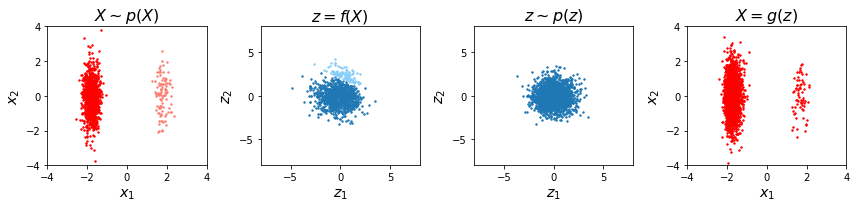

In [22]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(1,4, figsize = (12,3)) # width x height in inches
my_font_size = 16 # for paper
my_s = 2

# plot data sampled in real space 
plt.subplot(141)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r',s = my_s)
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon',s = my_s)
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X \sim p(X)$', fontsize = my_font_size)

# sample from x and transform to z 
plt.subplot(142)
plt.scatter(z_md_a[:, 0], z_md_a[:, 1], c='tab:blue',s = my_s)
plt.scatter(z_md_b[:, 0], z_md_b[:, 1], c='lightskyblue',s = my_s)
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z = f(X)$', fontsize = my_font_size)

# sampling from the multivariate gaussian with zero mean and unit variance
plt.subplot(143)
plt.scatter(z[:, 0], z[:, 1],s = my_s)
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z \sim p(z)$', fontsize = my_font_size)

# sample 1000 points from prior and transform back 
plt.subplot(144)
plt.scatter(x[:, 0], x[:, 1], c='r',s = my_s) # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X = g(z)$', fontsize = my_font_size)

fig.tight_layout()
plt.savefig("images/double_well_results.png", dpi=600, transparent=False)

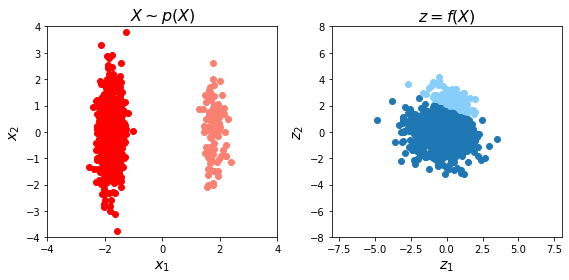

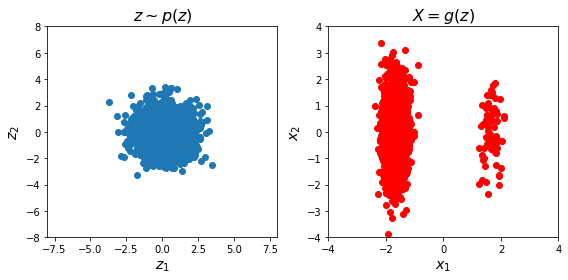

In [29]:
# Visualize the learned transformation (After training)
fig, axes = plt.subplots(2, 1, figsize = (8,4))
my_font_size = 16 # for paper
my_s = 2

# plot data sampled in real space 
plt.subplot(121)
plt.scatter(coords_state_a[:, 0], coords_state_a[:, 1], c='r')
plt.scatter(coords_state_b[:, 0], coords_state_b[:, 1], c='salmon')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X \sim p(X)$', fontsize = my_font_size)

# sample from x and transform to z 
z_md_a = model.f(torch.from_numpy(coords_state_a.astype('float32')))[0].detach().numpy()
z_md_b = model.f(torch.from_numpy(coords_state_b.astype('float32')))[0].detach().numpy()
plt.subplot(122)
plt.scatter(z_md_a[:, 0], z_md_a[:, 1], c='tab:blue')
plt.scatter(z_md_b[:, 0], z_md_b[:, 1], c='lightskyblue')
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z = f(X)$', fontsize = my_font_size)

fig.tight_layout()
plt.savefig("images/double_well_results_2x1_top.png", dpi=600, transparent=False)
fig, axes = plt.subplots(2, 1, figsize = (8,4))

# sampling from the multivariate gaussian with zero mean and unit variance
plt.subplot(121)
plt.scatter(z[:, 0], z[:, 1])
plt.xlim([-8,8])
plt.ylim([-8,8])
plt.xlabel(r"$z_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$z_2$",fontsize = 0.9*my_font_size)
plt.title(r'$z \sim p(z)$', fontsize = my_font_size)

# sample 1000 points from prior and transform back 
x = model.g(torch.from_numpy(z))[0].detach().numpy()
plt.subplot(122)
plt.scatter(x[:, 0], x[:, 1], c='r') # x[:, 0, 0] is x1 coordinates of all samples 
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel(r"$x_1$",fontsize = 0.9*my_font_size)
plt.ylabel(r"$x_2$",fontsize = 0.9*my_font_size)
plt.title(r'$X = g(z)$', fontsize = my_font_size)

fig.tight_layout()
plt.savefig("images/double_well_results_2x1_bottom.png", dpi=600, transparent=False)

### Free Energy
With our model now correctly generating the Boltzmann distribution (bottom right), we can utilize it to calculate the free energy as a function of the reaction coordinate for this system (the coordinate $x_1$). The Boltzmann distribution is given by: 

$p(x) = \exp(-f(x))$ so $f = -\log(p(x))$ where $f$ denote free energy. 

Steps:

1) Histogram the obtained samples to estimate probs

2) Filter probabilities to avoid single-sample, low-prob. states that are likely just noise

3) Calculate free energy

4) Shift free energy to lowest well reference state (we only get relative $f - f_0$)


Note: The smoothness of the average can be improved by generating more sample points.

In [24]:
z_fe, x_fe = model.sample(500000)

KeyboardInterrupt: 

In [ ]:
x1 = x_fe[:,0]
x2 = x_fe[:,1]

counts, bins = np.histogram(x1, bins = 200)
anchors = (bins[1:] + bins[:-1]) / 2

probs = counts / np.sum(counts)

anchors = anchors[np.where(probs > 0.0001)]
probs = probs[np.where(probs > 0.0001)]

f = -np.log(probs)
fn = f - np.min(f)

In [ ]:
# Visualize the results
plt.scatter(anchors, fn) 

plt.xlabel("$x_1$")
plt.ylabel(r"$(f - f_0) / k_B T$")

plt.show()

For the simple double well potential, we can also calculate this free energy analytically. The partition function $Z$ is given by: 
$$ \ln Z(x_1) = \sqrt{2\pi}\big( x_1^4 - 6*x_1^2 + x_1 \big)$$
from which we can calculate the free energy via $f=-k_B T \ln Z$

In [ ]:
fig, axes = plt.subplots(figsize = (6,4))
x1 = np.linspace(-2.5,2.5,1000)
logz = (x1**4 - 6*x1**2 + x1) + 11

plt.plot(x1,logz)
plt.scatter(anchors, fn,color='orange') 

plt.xlabel("$x_1$", fontsize = my_font_size)
plt.ylabel(r"$(f - f_0) / k_B T$", fontsize = my_font_size)

plt.tight_layout()
plt.savefig("images/double_well_fe.png", dpi=600, transparent=False)
plt.show()

## Notes
- List of Plotly colors: https://community.plot.ly/t/plotly-colours-list/11730/3